In [1]:
import scipy.io
import numpy as np
import pylab as pl

In [2]:
mat = scipy.io.loadmat('data/binaryalphadigs.mat')
data_digits = mat['dat'][:10,]
data_alpha = mat['dat'][10:,]
print("data_digits shape = {}".format(data_digits.shape))
print("data_alpha shape = {}".format(data_alpha.shape))

data_digits shape = (10, 39)
data_alpha shape = (26, 39)


In [3]:
def lire_alpha_digits(data, list_index):
    m, n = data.shape
    p, q = data[0, 0].shape
    matrix = np.zeros((len(list_index)*n, p*q))
    for i, index in enumerate(list_index):
        for j in range(n):
            matrix[i*n + j] = data[index, j].reshape(p*q)
    return matrix

In [4]:
data_alpha_reshaped = lire_alpha_digits(data_alpha, [0])
data_digits_reshaped = lire_alpha_digits(data_digits, [0])

In [101]:
class DbnModel():
    def __init__(self, d, q, p):
        self.d = d
        self.q = q
        self.p = p
        self.A = np.zeros((d, p))
        self.B = np.zeros((d, q))
        self.W = np.random.normal(0, 0.1, size=(d, p, q))
    
    def entree_sortie_RBM(self, d, H):
        A = np.tile(self.A[d, :], (H.shape[0], 1))
        Z = np.transpose(self.W[d, :, :] @ H.T) + A
        return np.exp(Z)/(1 + np.exp(Z))

    def sortie_entree_RBM(self, d, V):
        B = np.tile(self.B[d, :], (V.shape[0], 1))
        Z = np.transpose(self.W[d, :, :].T @ V.T) + B
        return np.exp(Z)/(1 + np.exp(Z))
    
    def entree_sortie_DBN(self, H):
        E = H.copy()
        for l in range(1, self.d + 1):
            E = self.entree_sortie_RBM(self.d - l, E)
            E = np.round(E)
        return E
    
    def sortie_entree_DBN(self, V):
        S = V.copy()
        for l in range(self.d):
            S = self.sortie_entree_RBM(l, S)
            S = np.round(S)
        return S
    
    def split_in_batches(self, indexes, batch):
        Batches = []
        N = len(indexes) // batch
        for i in range(N):
            Batches.append(indexes[i*batch:i*batch+batch])
        Batches.append(indexes[N*batch:len(indexes)])
        return Batches
    
    def train_RBM(self, l, X, niter, step, batch, verbose=True):
        assert(X.shape[1] == self.W[l, :, :].shape[0])
        batches_index = self.split_in_batches(np.arange(X.shape[0]), batch)
        for epoch in range(niter):
            loss = 0
            for batch in batches_index:
                X_batch = X[batch]
                Ph = self.sortie_entree_RBM(l, X_batch)
                H = np.round(Ph)
                Pv = self.entree_sortie_RBM(l, H)
                V = np.round(Pv)
                Mh = self.sortie_entree_RBM(l, V)
                loss += np.sum((V - X_batch)**2)

                # Compute the gradients
                grad_W = X_batch.T @ Ph - V.T @ Mh
                grad_a = np.sum(X_batch - V, axis=0)
                grad_b = np.sum(Ph - Mh, axis=0)

                # Update the parameters
                self.W[l, :, :] += step*grad_W
                self.A[l, :] += step*grad_a
                self.B[l, :] += step*grad_b
            loss /= X.shape[0]
            if verbose:
                print("Epoch {}/{} : MSE = {}".format(epoch + 1, niter, loss))
    
    def train_DBN(self, X, niter, step, batch, verbose=True):
        S = X.copy()
        for l in range(self.d):
            self.train_RBM(l, S, niter, step, batch, verbose=False)
            S = self.sortie_entree_RBM(l, S) ### CHANGE HERE
            if verbose:
                print('Training Layer {}/{} ...'.format(l+1, self.d))

    # def generer_image_DBN(self, n_images, n_iter):
    #     X = np.random.normal(0, 0.1, size=(n_images, self.W.shape[1]))
    #     # print(X[0, :]==X[1, :])
    #     S = X.copy()
    #     for _ in range(n_iter):
    #         for l in range(self.d):
    #             Ph = self.sortie_entree_RBM(l, S)
    #             H = np.round(Ph)
    #             Pv = self.entree_sortie_RBM(l, H)
    #             S = np.round(Pv)
    #     return S

    def generer_image_DBN(self, n_images, n_iter):
        X = np.random.normal(0, 0.1, size=(n_images, self.W.shape[1]))
        # print(X[0, :]==X[1, :])
        S = X.copy()
        for _ in range(n_iter):
            Ph = self.sortie_entree_DBN(S)
            H = np.round(Ph)
            Pv = self.entree_sortie_DBN(H)
            S = np.round(Pv)
        return S

    

Training Layer 1/2 ...
Training Layer 2/2 ...


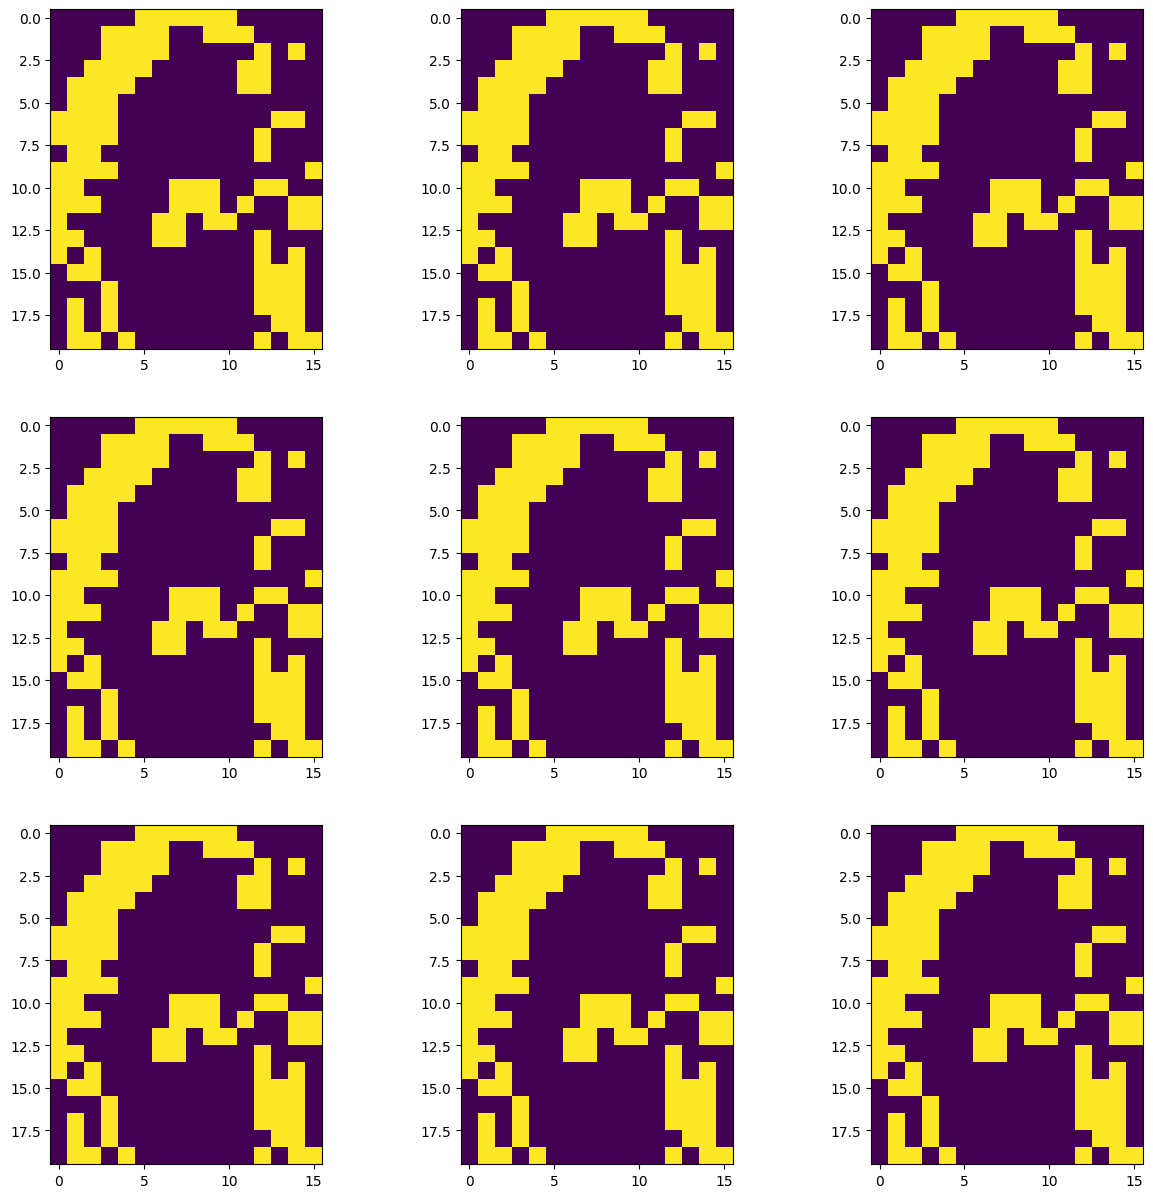

In [112]:
dbn = DbnModel(d=2, p=320, q=320)
dbn.train_DBN(data_alpha_reshaped, 60, 0.01, 10)
gen = dbn.generer_image_DBN(9, 300)

fig, ax = pl.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(gen[3*i + j,:].reshape(20,16))

In [81]:
dbn.W.shape

(2, 320, 100)

In [63]:
u = dbn.sortie_entree_DBN(data_alpha_reshaped)
ru = np.round(u)
m = dbn.entree_sortie_DBN(ru)
rm = np.round(m)

In [65]:
u

array([[0.33222353, 0.34317153, 0.45303689, ..., 0.32564052, 0.38588561,
        0.3832354 ],
       [0.3954358 , 0.37723979, 0.49292653, ..., 0.39412895, 0.40697666,
        0.40893136],
       [0.29368834, 0.29948901, 0.414923  , ..., 0.32223204, 0.34546049,
        0.35064504],
       ...,
       [0.35372245, 0.32695747, 0.47326386, ..., 0.3512262 , 0.4074549 ,
        0.38597005],
       [0.3063001 , 0.24914325, 0.39173592, ..., 0.29161866, 0.3399854 ,
        0.3842035 ],
       [0.41214176, 0.39677029, 0.47110868, ..., 0.41288081, 0.43921513,
        0.44334334]])

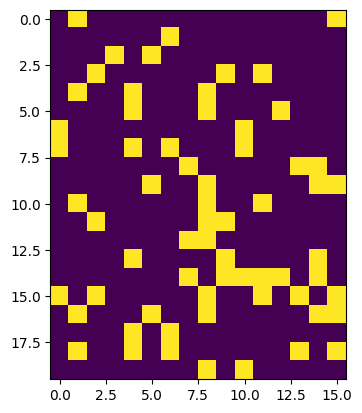

In [60]:
pl.imshow(m[2,:].reshape(20, 16))